# Измерение звездного фона и коэффициента его ослабления фильтрами

    Место измерений п.Научный КрАО.
    Измерения проводились в период 21:42 по 23:08 08.11.2018.
    В поле зрения прибора визуально наблюдался Млечный путь.
    Код питающего напряжения - 250. U1=-26.8В, U2=+2.05В (Общее ~28,8В).

    No.|~время |Назначение
    1 21:42 Без фильтров
    2 21:50 УФС-1
    3 21:56 Без фильтров
    4 22:02 УФС-5
    5 22:07 Без фильтров
    6 22:13 ФС6 (BG3)
    7 22:18 Без фильтров
    8 22:25 SL360\50
    9 22:30 Без фильтров
    10 22:35 SL280-380
    11 22:40 Без фильтров
    12 22:46 FF01-375/110
    13 22:56 Без фильтров
    14 23:04 С закрытой диафрагмой (собственный тепловой шум SiPM, пьедестал)


Сбой в записи в файл 08.11.2018   с  20:08:33 по 20:19:05  и  с  21:30:40 по 21:37:32, что не входит во временной интервал измерений.

In [1]:
!date
!pwd

Пн ноя 12 19:41:23 MSK 2018
/home/alena/Arduino/Detector/Data


In [2]:
import pandas as pd
import numpy as np

## Чтение файла данных

In [3]:
## ['date', 'time', 'On', 'u', 'i', 't', 'u5', 'dac', 'CH0', 'CH1', 'CH2', 'CH3', 'U']
dtype = {'date': str, 'time': str, 'On': str, 'u': str, 'i': str, 't': str, 'u5': str, 'dac': str,
         'CH0': np.uint8, 'CH1': np.uint8, 'CH2': np.uint8, 'CH3': np.uint8}

In [23]:
#data = pd.read_csv("data_measurements.txt", index_col=False, sep='\\s+',usecols=dtype.keys(), dtype=dtype)
data = pd.read_csv("data_measurements_1.txt", index_col=False, sep='\\s+')
data = data.drop(columns = "adc")

## reject lines
data = data[~data.On.isin(['OFF'])]
data = data[~data.date.isin(['OK','>','Recv','ADC_on:','DAC_write', 'ADC_off:','SEND','Start'])] #,'Input:'])]
data = data[~data.date.str.contains(r'AT+')]
data = data[~data.date.str.contains(r'SEN')]
data = data[data.date > '07.11.2018']

## add columns
data["U"]  = data.CH0 * 0.01528 - 36.91
data["I"]  = (4094.0 - data.CH1)/10.372
data["U5"] = (data.CH2 + 20.0)*0.01
data["T"]  = (data.CH3/2.0 - 500) * 0.1
#data['timestamp'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'])

## save data file
print(data.shape)
data.to_csv("data_input.csv")

data.drop(columns=['On', 'u', 'i', 't', 'u5', 'dac'], inplace = True)
data.head()
#data.describe()

(3041, 16)


,date,time,CH0,CH1,CH2,CH3,U,I,U5,T
0,Input:,21:c+measurements_begin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Input:,18:c+without+filters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Input:,2:n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,08.11.2018,21:42:10,1439.0,4094.0,474.0,1145.0,-14.92208,0.0,4.94,7.25
73,08.11.2018,21:42:11,1440.0,4094.0,474.0,1145.0,-14.90680,0.0,4.94,7.25


## Таблица результатов

In [6]:
table = pd.read_csv("table1.csv", index_col=False)
print(table.shape)
#table

(18, 6)


In [7]:
table['count'] = [0] * table.shape[0]
for i in range(table.shape[0]):
    part=data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
    #print(i, part.U.count(), part.U.mean(), sep='\t')
    table.loc[i, 'count'] = part.U.count()
    table.loc[i, 'U']     = part.U.mean()
    table.loc[i, 'Ustd'] = part.U.std()
    table.loc[i, 'I']    = part.I.mean()
    table.loc[i, 'Istd'] = part.I.std()
    table.loc[i, 'T']    = part['T'].mean()
    table.loc[i, 'Tstd'] = part['T'].std()
    table.loc[i, 'U5']   = part.U5.mean()
    table.loc[i, 'U5std'] = part.U5.std()

    name      --- комментарий к периоду измерений
    w         --- код DAC высокого напряжения
    begin     --- время начала периода измерений
    end       --- время окончания периода измерений
    count     --- количество измерений (секунд)
    U, Ustd   --- среднее и станд. отклонение напряжения источника  
    I, Istd   --- то же для тока SiPM
    T, Tstd   --- то же для температуры
    U5, U5std --- то же для напряжения 5В

In [8]:
table.drop(columns = ['N', 'time'])

,name,w,begin,end,count,U,Ustd,I,Istd,T,Tstd,U5,U5std
0,Без_фильтров,0,21:42:10,21:42:22,13,-14.905625,0.011606,0.037082,0.062711,7.215385,0.031521,4.941538,0.003755
1,Без_фильтров,230,21:42:23,21:42:43,20,-25.164264,0.007184,17.942538,0.168161,7.225000,0.025649,4.941000,0.003078
2,Без_фильтров,250,21:42:44,21:45:04,136,-26.767114,0.006394,37.688432,0.200830,7.245588,0.024699,4.940147,0.002103
3,УФС-1,250,21:50:29,21:53:54,199,-26.766691,0.005967,12.055554,0.144973,7.441960,0.043353,4.942915,0.004556
4,Без_фильтров,250,21:56:27,21:58:45,134,-26.766817,0.005881,38.019265,0.201319,7.443284,0.030529,4.941119,0.003609
5,УФС-5,250,22:02:53,22:05:35,157,-26.766221,0.005321,9.686785,0.128502,7.369108,0.050171,4.942739,0.004474
6,Без_фильтров,250,22:07:40,22:10:53,187,-26.767103,0.006104,37.986888,0.216050,7.264973,0.028215,4.940856,0.003165
7,ФС6_(BG3),250,22:13:13,22:16:29,190,-26.766573,0.005661,17.035744,0.150788,7.280000,0.040434,4.940526,0.002464
8,Без_фильтров,250,22:18:45,22:21:14,144,-26.765990,0.005383,38.444852,0.217986,7.174306,0.041386,4.941944,0.003972
9,SL360\50,250,22:25:08,22:28:23,189,-26.766748,0.005816,1.548736,0.091476,7.894444,0.129989,4.944233,0.004954


In [9]:
table.to_csv("results.csv")

## Визуальзация данных

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

In [54]:
plt.rcParams['figure.figsize'] =(10,6)
plt.rcParams['lines.markersize'] = 5
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [41]:
#plt.plot(table.U5);
print('Напряжение 5В стабильно.')
print('Разброс напряжения: {:.3f} +- {:.3f}'.format( table.U5.mean(), 0.5*(table.U5.max()-table.U5.min()) ) )

Напряжение 5В стабильно.
Разброс напряжения: 4.941 +- 0.002


In [50]:
def draw_parameter(param):
    plt.figure(figsize = (10,6))
    x = table.U[(table.name == 'Без_фильтров') & (table.w > 10)]
    y = table[param][(table.name == 'Без_фильтров') & (table.w > 10)]
    plt.plot(x, y, '*', label = 'Без_фильтров')
    x = table.U[table.name == 'С_закрытой_диафрагмой']
    y = table[param][table.name == 'С_закрытой_диафрагмой']
    plt.plot(x, y, 'o', label = 'С_закрытой_диафрагмой')
    for i in ['УФС-1', 'УФС-5', 'ФС6_(BG3)', 'SL360\50', 'SL280-380','FF01-375/110']:
        x = table.U[table.name == i]
        y = table[param][table.name == i]
        plt.plot(x, y, '>', label= i)
    plt.xlabel( 'U, V')
    plt.ylabel( 'I, uA')
    plt.legend()
    plt.grid()

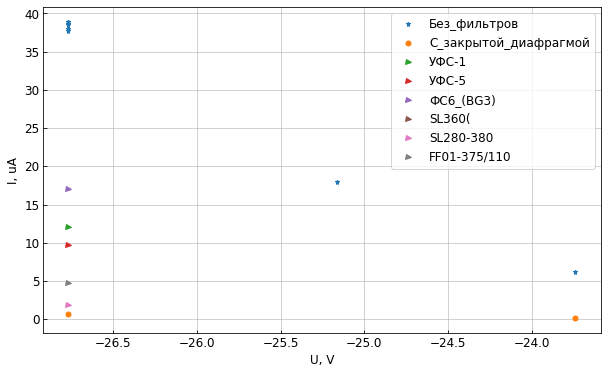

In [51]:
## график токов
draw_parameter('I')

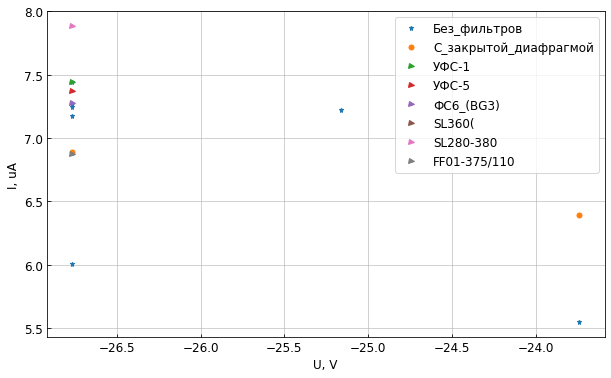

In [52]:
## график температур
draw_parameter('T')

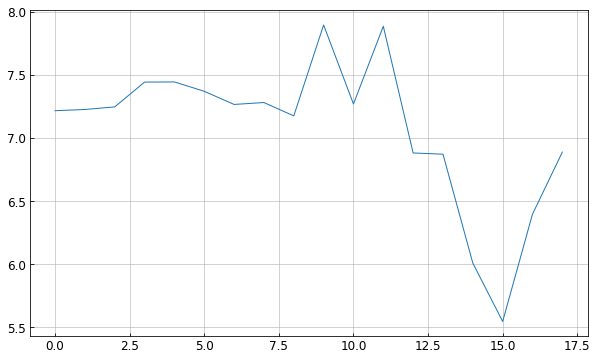

In [56]:
plt.plot(table['T']);
plt.grid()

## Учёт влияния температуры

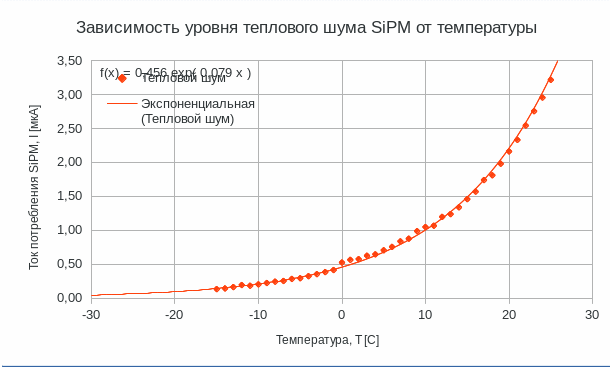

In [44]:
from IPython.display import Image 
Image("SiPM_AT.gif")

In [61]:
# Привeдeм все к температуре T = 7.44 grad C
def f(x):
    return 0.456 * np.exp(0.079*x)

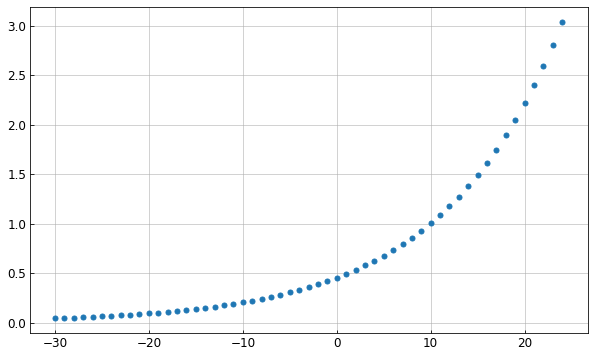

In [65]:
x = [x for x in range(-30,25,1)]
y = [f(i) for i in x]
plt.plot(x,y,'o')
plt.grid()

In [74]:
t2 = 7.441960
f2 = f(t2)
for i in range(table.shape[0]):
    print(i, f2, f(table['T'][i]), f2/ f(table['T'][i]),  sep='\t')
    table.loc[i, 'Inew'] = table.I[i] * f2/ f(table['T'][i])

0	0.8209052128630312	0.8063421806226759	1.0180606107311778
1	0.8209052128630312	0.8069549232432385	1.0172875698728314
2	0.8209052128630312	0.8082684796327677	1.0156343264010554
3	0.8209052128630312	0.8209051998275534	1.000000015879395
4	0.8209052128630312	0.8209910536503587	0.9998954424814426
5	0.8209052128630312	0.8161942382056446	1.0057718793356631
6	0.8209052128630312	0.8095072240889425	1.0140801569583477
7	0.8209052128630312	0.8104687706901426	1.0128770441876516
8	0.8209052128630312	0.8037296435621357	1.0213698342949915
9	0.8209052128630312	0.8507802934025726	0.9648850816465667
10	0.8209052128630312	0.8097390350713617	1.0137898474793
11	0.8209052128630312	0.8500830225523398	0.9656765175691858
12	0.8209052128630312	0.7852989062143144	1.0453410877908438
13	0.8209052128630312	0.7846943807847132	1.0461464144067227
14	0.8209052128630312	0.7330081482553832	1.119912806995188
15	0.8209052128630312	0.706711513330267	1.1615846033053068
16	0.8209052128630312	0.7557973798763697	1.0861445603282

In [72]:
table

,N,time,name,w,begin,end,count,U,Ustd,I,Istd,T,Tstd,U5,U5std,Inew
0,1.0,21:42,Без_фильтров,0,21:42:10,21:42:22,13,-14.905625,0.011606,0.037082,0.062711,7.215385,0.031521,4.941538,0.003755,0.037752
1,NaN,NaN,Без_фильтров,230,21:42:23,21:42:43,20,-25.164264,0.007184,17.942538,0.168161,7.225000,0.025649,4.941000,0.003078,18.252720
2,NaN,NaN,Без_фильтров,250,21:42:44,21:45:04,136,-26.767114,0.006394,37.688432,0.200830,7.245588,0.024699,4.940147,0.002103,38.277665
3,2.0,21:50,УФС-1,250,21:50:29,21:53:54,199,-26.766691,0.005967,12.055554,0.144973,7.441960,0.043353,4.942915,0.004556,12.055554
4,3.0,21:56,Без_фильтров,250,21:56:27,21:58:45,134,-26.766817,0.005881,38.019265,0.201319,7.443284,0.030529,4.941119,0.003609,38.015290
5,4.0,22:02,УФС-5,250,22:02:53,22:05:35,157,-26.766221,0.005321,9.686785,0.128502,7.369108,0.050171,4.942739,0.004474,9.742696
6,5.0,22:07,Без_фильтров,250,22:07:40,22:10:53,187,-26.767103,0.006104,37.986888,0.216050,7.264973,0.028215,4.940856,0.003165,38.521749
7,6.0,22:13,ФС6_(BG3),250,22:13:13,22:16:29,190,-26.766573,0.005661,17.035744,0.150788,7.280000,0.040434,4.940526,0.002464,17.255114
8,7.0,22:18,Без_фильтров,250,22:18:45,22:21:14,144,-26.765990,0.005383,38.444852,0.217986,7.174306,0.041386,4.941944,0.003972,39.266412
9,8.0,22:25,SL360\50,250,22:25:08,22:28:23,189,-26.766748,0.005816,1.548736,0.091476,7.894444,0.129989,4.944233,0.004954,1.494352


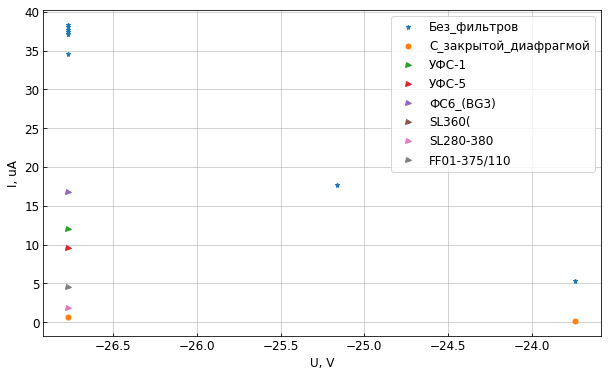

In [69]:
## график токов
draw_parameter('Inew')

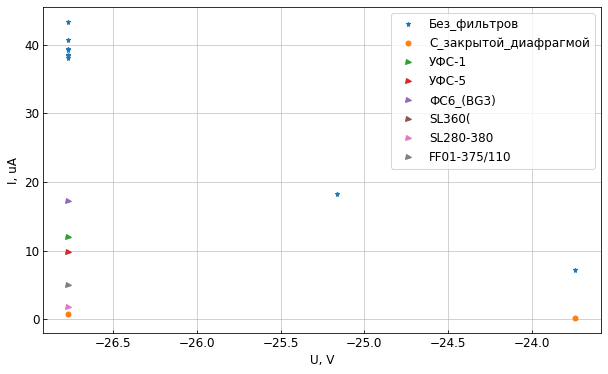

In [73]:
## график токов
draw_parameter('Inew')